<a href="https://colab.research.google.com/github/Adrok24/Proyecto-Integrador/blob/main/T-VAE-0127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install tensorflow-datasets==1.2.0

In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import re
import numpy as np

import matplotlib.pyplot as plt

tf.random.set_seed(1234)


In [33]:
from tensorflow.keras.layers import Layer, Dense
import tensorflow.keras.backend as K

In [34]:
## Vamos a bajarnos el dataset de dialogos de peliculas de Cornell University
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin=
    'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,
                                           'movie_conversations.txt')

### Preprocesamiento

In [35]:
# Numero máximo de samples a preprocesar
MAX_SAMPLES = 50000

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # vamos a crear espacios entre las frases y los puntos:
  # ej: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # reemplazamos por espacios todo lo que no sea (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence


def load_conversations():
  id2line = {}
  ## levanto las frases
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()

  ## y me quedo solo con id de frase y texto
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    ## me quedo con las conversaciones
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    ## nos quedamos con las frases consecutivas: una va a ser usada 
    ## como "pregunta" y la otra como "respuesta"
    for i in range(len(conversation) - 1):
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      if len(inputs) >= MAX_SAMPLES:
        return inputs
  return inputs


questions = load_conversations()

In [36]:
## ejemplo:
print("Linea 1")
print(questions[0])
print()
print("Linea 2")
print(questions[1])
print()
print("Linea 3")
print(questions[2])

Linea 1
can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .

Linea 2
well , i thought we d start with pronunciation , if that s okay with you .

Linea 3
not the hacking and gagging and spitting part . please .


In [37]:
## tokenizador de subwords
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions, target_vocab_size=2**13)

## Recien ahora ponemos los tokens de inicio y fin (sino el tokenizador me los rompe)
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Le agrego al tamaño del vocab los dos tokens especiales
VOCAB_SIZE = tokenizer.vocab_size + 2

In [38]:
## el tokenizador tiene dos metodos: encode y decode:
print(tokenizer.encode("hello"))
print(tokenizer.decode(tokenizer.encode("hello")))

[310]
hello


In [39]:
sample_string = 'Transformer is complicated.'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

assert original_string == sample_string

Tokenized string is [7970, 1864, 8001, 5961, 18, 4988, 7932]
The original string: Transformer is complicated.
7970 ----> T
1864 ----> ran
8001 ----> s
5961 ----> former 
18 ----> is 
4988 ----> complicated
7932 ----> .


In [40]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 50

In [41]:
# Tokenizamos, filtramos las secuencias menores al largo maximo
# y las paddeamos 
def tokenize_and_filter(inputs):
  tokenized_inputs = []
  
  for sentence1 in inputs:
    # tokenizamos + tokens especiales
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    # filtramos
    if len(sentence1) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
  
  # paddeamos
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs

questions = tokenize_and_filter(questions)

In [42]:
print('Tamaño vocabulario: {}'.format(VOCAB_SIZE))
print('frases: {}'.format(len(questions)))

Tamaño vocabulario: 8144
frases: 48319


In [43]:
# Adapto para que de un multiplo de 64
questions = questions[0:48256]
len(questions)

48256

In [44]:
### ver de modificar ESTO

# saco el token de start de los outputs
dataset = tf.data.Dataset.from_tensor_slices((questions,questions))

dataset = dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Elementos básicos

In [45]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculamos attention weights """

  ## hacemos el producto de query por la transpuesta de key
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  ## escalamos por la raiz cuadrado del # dims
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  ## agregamos la mascara
  if mask is not None:
    logits += (mask * -1e9)

  ## aplicamos la softmax
  attention_weights = tf.nn.softmax(logits, axis=-1)

  ## y multiplicamos por value 
  output = tf.matmul(attention_weights, value)

  return output

In [46]:
class MultiHeadAttention(tf.keras.layers.Layer):

  ''' Vamos a armar la capa para multihead attention '''

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)

    ## que es este super?
    ## super() te permite acceeder a los metodos de la super clase de la cual
    ## la subclase está heredando. En este caso, estas herendando de Layers.
        
    ## definimos algunos parametros: cuantas cabezas va a tener self attention 
    ## y la dimensionalidad del embedding
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    ## cuantas dimensiones va a tener cada cabeza:
    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    ## vamos a armar la division en cabezas. 
    ## se va a entender mejor en el siguiente bloque de codigo
    ## por ahora es solamente la forma en la que 
    ## reacomodamos los datos para armar las cabezas
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])


  def get_config(self):
          config = super().get_config().copy()
          config.update({
              'num_heads': self.num_heads,
              'd_model': self.d_model,
              'depth': self.depth,
              'query_dense': self.query_dense,
              'key_dense': self.key_dense,
              'value_dense': self.value_dense,
              'dense': self.dense             
          })
          return config

  def call(self, inputs):
    ''' Este call es el metodo que  va a llamar keras para usar la capa'''

    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # print(self.name, mask)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    # acomodamos las dimensiones
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenamos las cabezas
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [47]:
## creamos una mascara para el padding (asi nos nos molesta)
## con esto lo que hacemos es despues pasarselo a la capa 
## anterior y eliminamos los paddings

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)

  return mask[:, tf.newaxis, tf.newaxis, :]

In [48]:
## vamos a mostrar como funciona:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [49]:
## vamos a crear la otra mascara:
## ahora queremos la mascara para no ver el futuro
## vamos a incorporarle tambien la mascara para el padding

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

  ## aca la mascara para el padding
  padding_mask = create_padding_mask(x)

  return tf.maximum(look_ahead_mask, padding_mask)

In [50]:
#print(create_look_ahead_mask(tf.constant([[0,1, 2,3,4, 5,6,7]])))

In [51]:
a = tf.constant([2,4,6])
b = tf.constant([1,3,5])

In [52]:
c= tf.concat([b,a],axis=-1)
c

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([1, 3, 5, 2, 4, 6], dtype=int32)>

In [53]:
class PositionalEncoding(tf.keras.layers.Layer):
  ''' Armamos los encodings de posición '''

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  ## comparar con formula de la teorica
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

   
  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # seno a los indices pares
    sines = tf.math.sin(angle_rads[:, 0::2])
    # coseno a los impares
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, :]
    return tf.cast(pos_encoding, tf.float32)

  def get_config(self):

          config = super().get_config().copy()
          config.update({
              'pos_encoding': self.pos_encoding
          })
          return config

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder

In [54]:
class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

In [225]:
## ya tenemos todos los ingredientes para armar una capa de encoder
## todavía no es el encoder entero!

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [226]:
## ahora si: el encoder
## vamos a definir una funcion que nos devuelva un modelo que tenga
## num_layers bloques de encoder:

def encoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout, name="encoder"):
  
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  print('enc_inputs',inputs)

  padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  print('enc_padding_mask',padding_mask)

  ## partimos de los embeddings
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  print('embeddings',embeddings)

  ## y les sumamos el positional encoding
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  print('PositionalEncoding',embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  ## y usamos tantos bloques como querramos
  for i in range(num_layers):
    outputs = encoder_layer(
                            units=units,
                            d_model=d_model,
                            num_heads=num_heads,
                            dropout=dropout,
                            name="encoder_layer_{}".format(i),
                        )([outputs, padding_mask])

  outputs  = tf.keras.layers.Reshape([50 * d_model])(outputs)
  # Generamos la media
  
  outputs = tf.keras.layers.Dense(500)(outputs)

  outputs = tf.keras.layers.Dense(200)(outputs)
  

  mu = Dense(200, name='mu')(outputs) #TODO: revisar la dimensionalidad del espacio latente


  # Generamos el logaritmo de la varianza
  logvar = Dense(200, name='logvar')(outputs)
  # Usamos esos parámetros para samplear el espacio latente
  z = Sampling(name='encoder_output')([mu, logvar])

  #output = Dense(d_model, name='latent space')(outputs)

  return tf.keras.Model(
      inputs=inputs, outputs=[mu, logvar, z], name=name)

### Decoder

In [227]:
## vamos a usar las mismas partes que ya tenemos para armar el decoder
## primero la decoder layer

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  
  decoder_input = tf.keras.Input(shape=(None, d_model), name="decoder_input_layer")
  
  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': decoder_input,
          'key': decoder_input,
          'value': decoder_input,
          'mask': None #padding_mask
      })

  #Normalization1
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + decoder_input)

  #FeedFoward
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)

  #Normalization2
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

  return tf.keras.Model(
      inputs=[decoder_input, padding_mask],
      outputs=outputs,
      name=name)

In [228]:
## y ahora usamos la decoder layer para el decoder

def decoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout, name='decoder'):

  decoder_input = tf.keras.Input(shape=(200), name='decoder_input')

  output = tf.keras.layers.Dense(500)(decoder_input)

  
  output = Dense(50 * d_model, name='linear_proyection',activation='relu')(output)

  output = tf.keras.layers.Reshape([50, d_model])(output)
 # print('linear_proyection', output.shape)

  ## la mascara para no ver el futuro y para el padding
  ## ojo que la toma de afuera (es un input, no la creamos aca)

  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name='look_ahead_mask')
  
  padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(output)

  outputs = tf.keras.layers.Dropout(rate=dropout)(output)

  ## vamos a tener num_layers bloques de decoders
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

#  print('final', output.shape)

  return tf.keras.Model(
      inputs=[decoder_input],
      outputs=outputs,
      name=name)

### Modelo VAE

In [229]:
from tensorflow.keras.models import Model

class VAEModel(Model):
    def __init__(self, encoder, decoder, r_loss_factor, vocab_size, num_layers, units, d_model, num_heads, dropout, mask=None,  **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout)
        
        self.decoder = decoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout)
        
        self.r_loss_factor = r_loss_factor

    def loss_function(self, y_true, y_pred):
      print("ytrue:",y_true,"ypred:",y_pred)
      y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH)) #(-1, MAX_LENGTH - 1))
      
      ## calculamos la loss sin reducir
      loss = tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True, reduction='none')(y_true, y_pred)

      print("loss:",loss)

      ## aplicamos una mascara
      mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
      loss = tf.multiply(loss, mask)

      print("loss2:",loss)

      ## y reducimos la loss
      return tf.reduce_mean(loss)

    # Definimos el train step para que utilice la función de costo compuesta por el error de reconstrucción y la divergencia KL
    def train_step(self, data):

        # print(data)
        data = data[0]
        
        # Iniciamos el cálculo de la loss dentro del contexto que registra las operaciones para poder derivarlas
        with tf.GradientTape() as tape:
            # Usamos el encoder para mapear las imágenes al espacio latente y obtenemos los parámetros de la distribución
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruimos la imágen a partir de z
            print("data:",data, "z:",z)
            # dict_decoder = {
            #     "inputs_dec": data,
            #     "decoder_input": z        
            # }
            reconstruction = self.decoder(z)

            reconstruction_loss = self.loss_function(data, reconstruction)

            print("checkpoint2_rec:", reconstruction_loss)

            # Escalamos la pérdida con el r_loss_factor
            reconstruction_loss *= self.r_loss_factor
            # Calculamos la divergencia KL usando la media y la varianza
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_sum(kl_loss, axis = 1)
            kl_loss *= -0.5
            # Combinamos las pérdidas
            total_loss = reconstruction_loss + kl_loss
        # Calculamos los gradientes
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Actualizamos los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # El método train_step debe devolver un diccionario
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    
    def call(self,inputs):
        mu, logvar, z = self.encoder(inputs)
        print("checkpoint_call")
        # dict_decoder = {
        #   "inputs_dec": inputs,
        #   "decoder_input": z            
        #     }
        return self.decoder(z)


In [230]:
# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = VAEModel(encoder, decoder, 10000,
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

enc_inputs KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
enc_padding_mask KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, None), dtype=tf.float32, name=None), name='enc_padding_mask/strided_slice:0', description="created by layer 'enc_padding_mask'")
embeddings KerasTensor(type_spec=TensorSpec(shape=(None, None, 256), dtype=tf.float32, name=None), name='tf.math.multiply_24/Mul:0', description="created by layer 'tf.math.multiply_24'")
PositionalEncoding KerasTensor(type_spec=TensorSpec(shape=(None, None, 256), dtype=tf.float32, name=None), name='positional_encoding_24/add:0', description="created by layer 'positional_encoding_24'")


enc_inputs KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")
enc_padding_mask KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, None), dtype=tf.float32, name=None), name='enc_padding_mask/strided_slice:0', description="created by layer 'enc_padding_mask'")
embeddings KerasTensor(type_spec=TensorSpec(shape=(None, None, 256), dtype=tf.float32, name=None), name='tf.math.multiply_25/Mul:0', description="created by layer 'tf.math.multiply_25'")
PositionalEncoding KerasTensor(type_spec=TensorSpec(shape=(None, None, 256), dtype=tf.float32, name=None), name='positional_encoding_25/add:0', description="created by layer 'positional_encoding_25'")


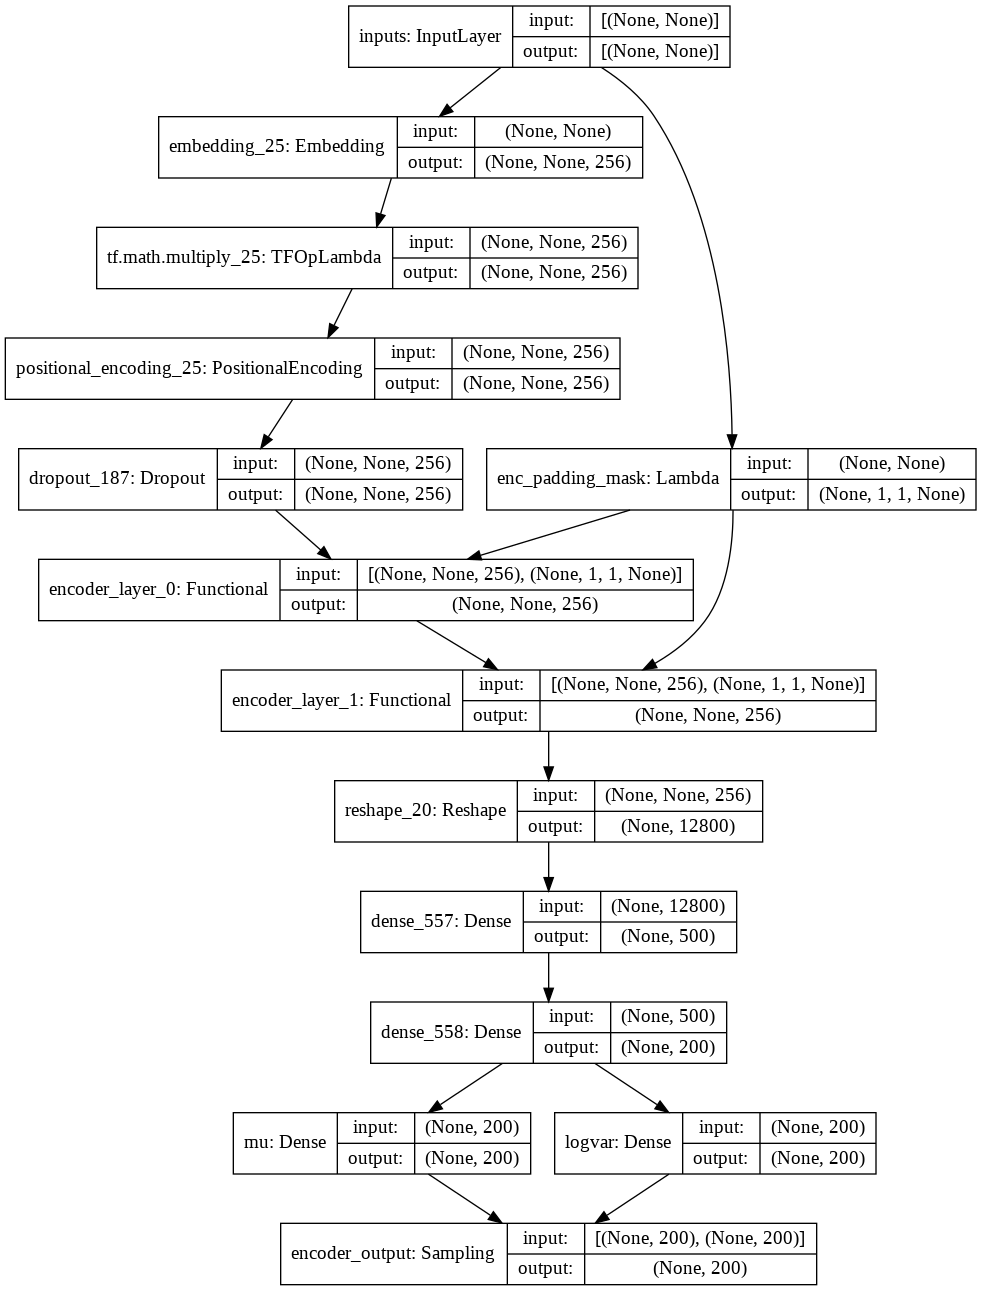

In [231]:
eo = encoder(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT,
  )
tf.keras.utils.plot_model(eo, show_shapes=True)

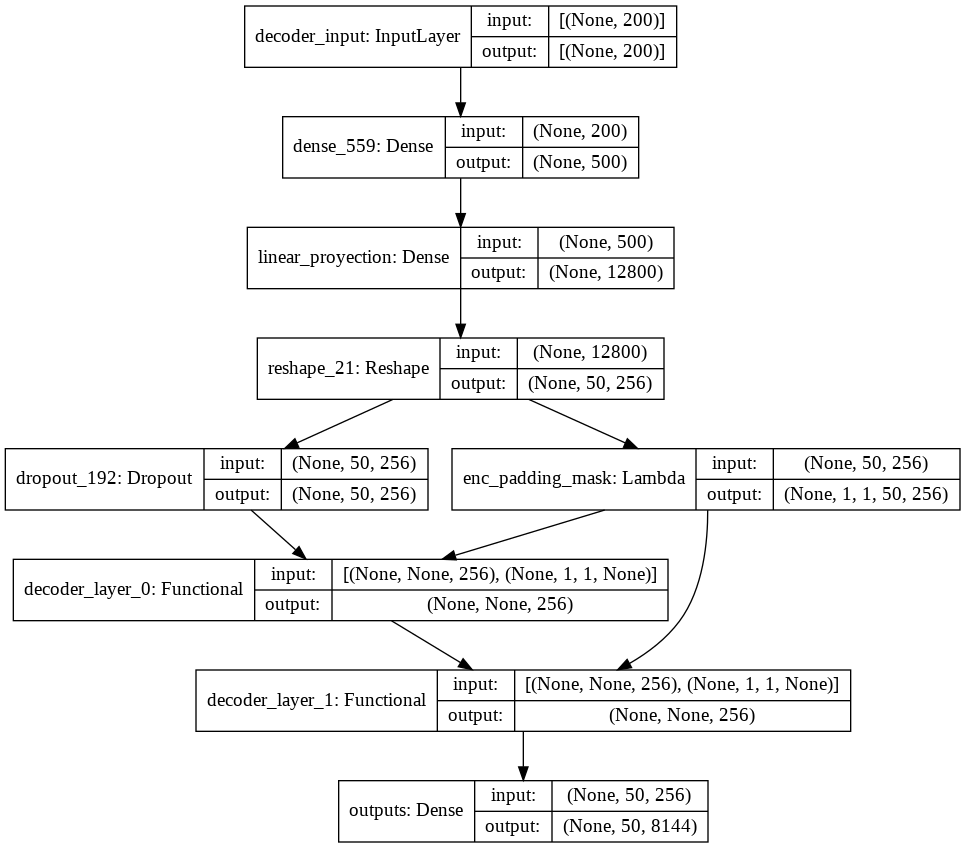

In [232]:
do = decoder(
  vocab_size=VOCAB_SIZE,
  num_layers=NUM_LAYERS,
  units=UNITS,
  d_model=D_MODEL,
  num_heads=NUM_HEADS,
  dropout=DROPOUT
)
    
tf.keras.utils.plot_model(do, show_shapes=True)
    

Text(0.5, 0, 'Train Step')

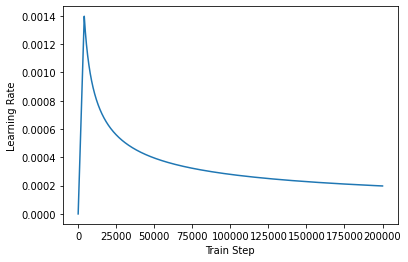

In [233]:
## veamos que pinta tiene
sample_learning_rate = CustomSchedule(d_model=128)
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Entrenamiento

In [234]:
EPOCHS = 20

d_model = D_MODEL

## nos queda armar el lr que va cambiando con el tiempo
## hay que hacer un schedule de lr:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

optimizer = tf.keras.optimizers.Adam(CustomSchedule(d_model), beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

model.compile(optimizer=optimizer, loss = loss)#, metrics = metrics) # masked_

history = model.fit(dataset, epochs=EPOCHS)

Epoch 1/20
data: Tensor("IteratorGetNext:0", shape=(None, 50), dtype=int32) z: Tensor("encoder/encoder_output/add:0", shape=(None, 200), dtype=float32)


ytrue: Tensor("IteratorGetNext:0", shape=(None, 50), dtype=int32) ypred: Tensor("decoder/outputs/BiasAdd:0", shape=(None, 50, 8144), dtype=float32)
loss: Tensor("sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(None, 50), dtype=float32)
loss2: Tensor("Mul:0", shape=(None, 50), dtype=float32)
checkpoint2_rec: Tensor("Mean:0", shape=(), dtype=float32)
data: Tensor("IteratorGetNext:0", shape=(None, 50), dtype=int32) z: Tensor("encoder/encoder_output/add:0", shape=(None, 200), dtype=float32)


ytrue: Tensor("IteratorGetNext:0", shape=(None, 50), dtype=int32) ypred: Tensor("decoder/outputs/BiasAdd:0", shape=(None, 50, 8144), dtype=float32)
loss: Tensor("sparse_categorical_crossentropy/weighted_loss/Mul:0", shape=(None, 50), dtype=float32)
loss2: Tensor("Mul:0", shape=(None, 50), dtype=float32)
checkpoint2_rec: Tensor("Mean:0", shape=(), dtype=float32)
754/754 [==============================] - 41s 48ms/step - loss: 17550.0977 - reconstruction_loss: 17403.3837 - kl_loss: 146.7167
Epoch 2/20
754/754 [==============================] - 36s 48ms/step - loss: 10059.4424 - reconstruction_loss: 9737.1642 - kl_loss: 322.2781
Epoch 3/20
754/754 [==============================] - 37s 48ms/step - loss: 7151.2485 - reconstruction_loss: 6768.5277 - kl_loss: 382.7204
Epoch 4/20
754/754 [==============================] - 36s 48ms/step - loss: 5823.4727 - reconstruction_loss: 5438.8173 - kl_loss: 384.6558
Epoch 5/20
754/754 [==============================] - 36s 48ms/step - loss: 5020.0142 - 

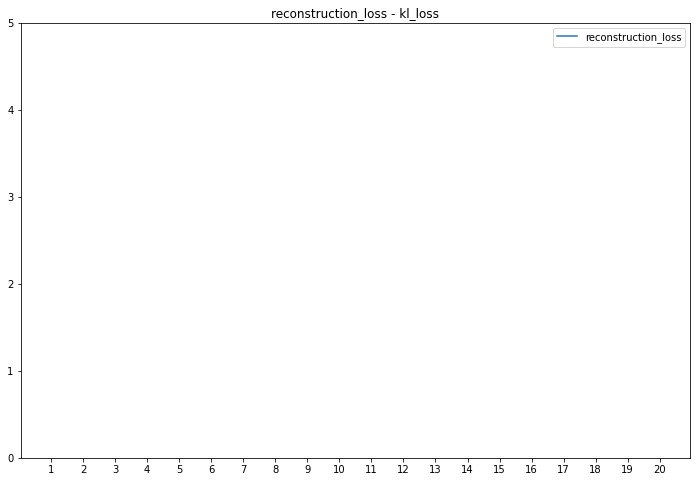

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

In [235]:
reconstruction_loss = history.history['reconstruction_loss']


epochs = range(1, len(reconstruction_loss) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, reconstruction_loss, label='reconstruction_loss')
plt.xticks(ticks=epochs)
plt.ylim([0, 5])
plt.title('reconstruction_loss - kl_loss')
plt.legend()
plt.show()
plt

In [236]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
model.save_weights('/content/drive/My Drive/Colab Notebooks/desafio final/weights.HDF5', save_format='tf')
# model.load_weights('/content/drive/My Drive/Colab Notebooks/desafio final/weights.HDF5')

## Testeamos

In [285]:
z_sampled = tf.random.normal(shape=(1,200))

In [286]:
result = model.decoder(z_sampled)
print(result.shape)
prediction = np.argmax(result, axis=2)

pred = prediction[0]
print(pred[0])
tokenizer.decode([i for i in pred if i < tokenizer.vocab_size])

(1, 50, 8144)
8142


'who seems got look things so quite quite is so seem they said d so absolutely latemuch as '